<a href="https://colab.research.google.com/github/aren4/Liver_Tumors/blob/main/Tommy_Rads.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install scikit_survival

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sksurv.linear_model import CoxnetSurvivalAnalysis
from sksurv.metrics import concordance_index_censored
from sksurv.linear_model import CoxPHSurvivalAnalysis
from lifelines import CoxPHFitter
from sksurv.nonparametric import kaplan_meier_estimator
from tqdm import tqdm
import re

pd.set_option('display.max_columns', None)

df = pd.read_csv('/content/drive/MyDrive/Tommy Rads/Secondary Analysis.csv', index_col=False, encoding='latin1')

In [3]:
numeric_cols = df.select_dtypes(include=np.number).columns

# Apply the mask to only the numeric columns
df[numeric_cols] = df[numeric_cols].mask(df[numeric_cols] < 0)

print(df)

    Date Ablation  Last Name        ID # First Name        DOB Sex   Race  \
0      12/22/2022     HORNER  8471498543       JOSH  9/26/1972   M  White   
1      12/19/2022     TAYLOR  8474225240     DONALD  9/22/1949   M  Black   
2       9/28/2022  DOUGHERTY  8443623400     ANDREA  3/20/1981   F  White   
3        8/3/2022       TORO  8464386796      CAROL  8/12/1959   F  White   
4       7/19/2022     KOFFEL  1002771556    MICHELE  9/20/1983   F  White   
..            ...        ...         ...        ...        ...  ..    ...   
132     4/16/2015    ANSELMO   441880150     JOSEPH  7/26/1945   M  White   
133     2/17/2015     RUDMAN   442666962  CATHERINE   3/9/1964   F  White   
134     2/12/2015    MCMAHON   443552039    MICHAEL  3/21/1966   M  White   
135     1/28/2015  WILKINSON    59872176      DEBRA  12/2/1963   F  White   
136      1/6/2015      EWING     6698286       ANNE   2/8/1938   F  White   

       Ethnicity  type of cancer Date Dx Different Primary  \
0    NotHispa

In [4]:
# Replace '-' with NaN
df.replace('-', np.nan, inplace=True)

# Helper function to flag unexpected values
def flag_unexpected(series, expected_type, allowed_values=None, pattern=None):
    flagged = []
    for idx, val in series.items():
        if pd.isna(val):
            continue
        if allowed_values is not None and val not in allowed_values:
            flagged.append((idx, val))
        elif expected_type == 'numeric':
            try:
                float(str(val).replace('A','')) # '12A' becomes '12'
            except:
                flagged.append((idx, val))
        elif expected_type == 'binary':
            if str(val) not in ['0', '1']:
                flagged.append((idx, val))
        elif pattern is not None:
            if not re.match(pattern, str(val)):
                flagged.append((idx, val))
    return flagged

# Cleaning report dictionary
cleaning_report = {}

# Sex: Recode to binary Sex: Male
df['Sex'] = df['Sex'].str.strip().str.upper().replace({'MALE': 'M', 'FEMALE': 'F'})
sex_binary = df['Sex'].map({'M': 1, 'F': 0})
df['Sex: Male'] = sex_binary
cleaning_report['Sex'] = flag_unexpected(df['Sex'], 'str', allowed_values=['M', 'F'])

# Race
allowed_races = ['White', 'Black', 'Asian', 'Other', 'Unknown']
df['Race'] = df['Race'].astype(str).str.strip().str.title()
cleaning_report['Race'] = flag_unexpected(df['Race'], 'str', allowed_values=allowed_races)

# Ethnicity
allowed_ethnicities = ['Hispanic', 'Nothispanic', 'Unknown']
df['Ethnicity'] = df['Ethnicity'].astype(str).str.strip().str.title()
cleaning_report['Ethnicity'] = flag_unexpected(df['Ethnicity'], 'str', allowed_values=allowed_ethnicities)

# Type of cancer
df['type of cancer'] = df['type of cancer'].astype(str).str.strip().str.lower()

# Age
df['Age Date Dx Liver Cancer'] = pd.to_numeric(df['Age Date Dx Liver Cancer'], errors='coerce')
cleaning_report['Age Date Dx Liver Cancer'] = flag_unexpected(df['Age Date Dx Liver Cancer'], 'numeric')

# CAT HCV
allowed_hcv = [0, 2]
df['CAT HCV (2SVR, 1 for chronic/present, 3 HBV 4 HAV)'] = pd.to_numeric(
    df['CAT HCV (2SVR, 1 for chronic/present, 3 HBV 4 HAV)'], errors='coerce'
)
cleaning_report['CAT HCV'] = flag_unexpected(
    df['CAT HCV (2SVR, 1 for chronic/present, 3 HBV 4 HAV)'], 'numeric', allowed_values=allowed_hcv)

# Define a mapping of scores to integers
score_mapping = {
    '5': 1,
    '6': 2,
    '7': 3,
    '8': 4,
    '9': 5,
    '10': 6,
    '11': 7,
    '12': 8,
    '13': 9,
    '14': 10,
    '15': 11
}

# Function to extract the relevant score from the string, while handling NaN values
def extract_score(text):
    if isinstance(text, str):  # Check if the entry is a string
        for score in score_mapping:
            if re.search(score, text):
                return score
    return None  # Return None if NaN or no match is found

# Apply the function to extract the score and then map it to the integer value
df['SCALAR CPT Score (Extracted)'] = df['CPT Score'].apply(extract_score)
df['SCALAR CPT Score (Recode)'] = df['SCALAR CPT Score (Extracted)'].map(score_mapping)

# Binary columns
binary_cols = ['EtOH', 'NASH', 'Ascites', 'Encephalopathy', 'First CEA Elevated',
               'Unilobar (0), Bilobar (1)', 'Bx during ablation (0no, 1yes, 2NGS)']
for col in binary_cols:
    allowed = ['0', '1'] if 'Bx during ablation' not in col else ['0', '1', '2']
    df[col] = df[col].astype(str).str.strip()
    df[col].replace('', np.nan, inplace=True)
    cleaning_report[col] = flag_unexpected(df[col], 'binary', allowed_values=allowed)
    df[col] = pd.to_numeric(df[col], errors='coerce')

# Scalar numeric columns
scalar_cols = ['WBC', 'Hgb', 'Plt', 'Na', 'Cr', 'Albumin', 'Tbili', 'INR', 'CEA',
               '#tumors to ablate', 'Longest Diameter Largest lesion (mm)',
               'Sum Longest Diameters', 'PS', 'Time to recur', 'SCALAR CPT Score (Recode)']
for col in scalar_cols:
    df[col] = pd.to_numeric(df[col], errors='coerce')
    cleaning_report[col] = flag_unexpected(df[col], 'numeric')

# Segment Largest Index Lesion (integer, sometimes with an 'A' suffix)
def clean_segment(x):
    if pd.isna(x):
        return np.nan
    if isinstance(x, str) and x.endswith('A'):
        x = x[:-1]
    try:
        return int(x)
    except:
        return np.nan
df['Segment Largest Index Lesion'] = df['Segment Largest Index Lesion'].apply(clean_segment)
cleaning_report['Segment Largest Index Lesion'] = flag_unexpected(df['Segment Largest Index Lesion'], 'numeric')


/tmp/ipython-input-4-1728181756.py:92: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[col].replace('', np.nan, inplace=True)
/tmp/ipython-input-4-1728181756.py:92: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try usi

In [5]:
df.head()

,Date Ablation,Last Name,ID #,First Name,DOB,Sex,Race,Ethnicity,type of cancer,Date Dx Different Primary,Date Dx Liver Cancer,Age Date Dx Liver Cancer,"CAT HCV (2SVR, 1 for chronic/present, 3 HBV 4 HAV)",EtOH,NASH,Ascites,Encephalopathy,WBC,Hgb,Plt,Na,Cr,Albumin,Tbili,INR,AFP,IU/ng,CEA,First CEA Elevated,#tumors to ablate,Longest Diameter Largest lesion (mm),Sum Longest Diameters,Segment Largest Index Lesion,"Unilobar (0), Bilobar (1)","Bx during ablation (0no, 1yes, 2NGS)",BCLC Stage,Native NaMELD,CPT Score,PS,"Liver Treatment prior to initial ablation (0none, 1TACE, 2TARE, 3EBRT, 4Systemic Therapy, 5resection, 6combined/other)",First ablation parameters,First ablation probe,First ablation total energy,Date PostAblation Imaging,"Recur (0no, 1yes)",Date of Imaging Recurrence,Time to recur,"Recurrence Local (0no, 1yes)",Recurrence EHD,Site of EHD,Description hepatic Recurrence,Size recurrent disease liver (mm),Treatment recurrence,Additional Details of Initial Repeat Tx/Rp Ablation parameters,Repeat ablation probe,Repeat ablation total energy,Ascites2,Encephalopathy2,WBC2,Hgb5,Plt6,Na7,Cr8,Albumin2,Tbili2,INR11,AFP12,AFP unit,CEA13,Second CEA Elevated,# tumors to ablate,Longest Diameter Largest lesion,Sum Longest Diameters15,Segment of Largest Index Lesion16,"Unilobar (0), Bilobar (1)17",BCLC,Native NaMELD18,CPT Score19,PS20,"Bx recurrence (0no,1yes,2NGS)",Date of Repeat Tx,Date Imaging after repeat treatment,Results followup Imaging at target lesion,Nontarget results,Date of first progression from Repeat,"Progression Local(0no,1yes)",TTP after repeat treatment,Date of last liver imaging,Response at last liver imaging,Nontarget response at last imaging,Date last follow up,Days between follow up and first ablation,"Status at last follow up (0alive, 1dead, 2LTFU)",Other notes,Time to recurrence post ablation,Sex: Male,SCALAR CPT Score (Extracted),SCALAR CPT Score (Recode)
0,12/22/2022,HORNER,8471498543,JOSH,9/26/1972,M,White,Nothispanic,colon,11/18/2021,11/2/2021,49,0,0,0,0,0,8.74,16.5,174.0,141.0,0.82,4.4,0.5,0.9,NaN,NaN,7.3,1.0,1,30,30,6.0,0,0,NaN,NaN,NaN,1.0,"4, 5",20cm Neuwave mp,PR20,650,1/18/2023,0,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4/4/2023,CR,NaN,7/7/2023,197,0.0,"MWA was for recurrence, lung metastases but no...",44917,1,None,NaN
1,12/19/2022,TAYLOR,8474225240,DONALD,9/22/1949,M,Black,Unknown,colon,9/8/2021,10/26/2022,73,0,0,0,0,0,11.50,13.5,151.0,141.0,0.81,3.8,0.9,1.0,NaN,NaN,4.0,0.0,1,19,19,4.0,0,0,NaN,NaN,NaN,NaN,4,PR 65Wx10m,PR15,650,2/14/2023,0,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2/14/2023,CR,NaN,7/17/2023,210,0.0,Only Continuity of Care notes available (VA). ...,44914,1,None,NaN
2,9/28/2022,DOUGHERTY,8443623400,ANDREA,3/20/1981,F,White,Nothispanic,leiomyosarcoma,11/13/2017,7/15/2022,41,0,0,0,0,0,3.80,13.0,211.0,136.0,0.94,4.6,0.7,1.0,NaN,NaN,2.4,NaN,1,22,22,2.0,1,1,NaN,NaN,NaN,0.0,"4,5",2 PR 65Wx5m,PR15,650,10/19/2022,1,10/21/2022,23.0,0.0,0.0,NaN,Enhancing diffusion restricting neoplasm in th...,12x9,0.0,Pr 65Wx5m,PR15,325.0,0.0,0.0,4.0,11.0,264.0,138.0,1.0,4.0,1.0,1.0,NaN,NaN,NaN,NaN,1.0,12.0,12.0,2,0.0,NaN,NaN,NaN,0.0,0.0,12/29/2022,1/31/2023,CR,PD,1/31/2023,0.0,0.0,8/28/2023,PD,PD,8/9/2023,315,1.0,"On lanreotide, DOTATATE, pazopanib",23,0,None,NaN
3,8/3/2022,TORO,8464386796,CAROL,8/12/1959,F,White,Nothispanic,lung,10/16/2018,1/6/2022,62,0,0,0,0,0,5.00,9.5,248.0,139.0,1.03,3.7,0.4,0.9,NaN,NaN,NaN,NaN,1,23,23,5.0,0,0,NaN,NaN,NaN,1.0,"6 (Bland embo), 4",15cm Neuwave mp,PR15,650,9/20/2022,1,9/20/2022,48.0,0.0,1.0,"Lung, Brain",postablation changes in the treated lesion. H...,Segment 7 (25/25) 1.5 x 1.5 cm. Inferior segme...,2.0,y90,NaN,NaN,0.0,0.0,10.0,10.0,136.0,139.0,1.0,4.0,0.0,1.0,NaN,NaN,NaN,NaN,3.0,16.0,44.0,7,1.0,NaN,NaN,NaN,1.0,0.0,11/16/2022,12/

In [6]:
# Liver Treatment prior to initial ablation
treatment_map = {
    '1': 'TACE',
    '2': 'TARE',
    '3': 'EBRT',
    '4': 'Systemic Therapy',
    '5': 'Resection',
    '6': 'Combined/Other'
}
def treatment_flags(cell):
    flags = {name: 0 for name in treatment_map.values()}
    if pd.isna(cell):
        return pd.Series(flags)
    items = re.findall(r'\d', str(cell))
    for item in items:
        if item in treatment_map:
            flags[treatment_map[item]] = 1
    return pd.Series(flags)
treatments = df['Liver Treatment prior to initial ablation (0none, 1TACE, 2TARE, 3EBRT, 4Systemic Therapy, 5resection, 6combined/other)'].apply(treatment_flags)
df = pd.concat([df, treatments], axis=1)
df.drop(columns=['Liver Treatment prior to initial ablation (0none, 1TACE, 2TARE, 3EBRT, 4Systemic Therapy, 5resection, 6combined/other)'], inplace=True)

# Recur (dependent)
df['Recur (0no, 1yes)'] = pd.to_numeric(df['Recur (0no, 1yes)'], errors='coerce')
cleaning_report['Recur (0no, 1yes)'] = flag_unexpected(df['Recur (0no, 1yes)'], 'binary', allowed_values=['0', '1'])

# Gather cleaning report and summarize any flagged values
flagged_summary = {col: flagged for col, flagged in cleaning_report.items() if flagged}
flagged_summary  # Show all columns with flagged/unexpected values and what those are


{'First CEA Elevated': [(0, '1.0'),
  (1, '0.0'),
  (2, 'nan'),
  (3, 'nan'),
  (4, 'nan'),
  (5, '0.0'),
  (6, '1.0'),
  (7, '1.0'),
  (8, '1.0'),
  (9, '0.0'),
  (10, 'nan'),
  (11, 'nan'),
  (12, '0.0'),
  (13, 'nan'),
  (14, '1.0'),
  (15, 'nan'),
  (16, '1.0'),
  (17, 'nan'),
  (18, 'nan'),
  (19, 'nan'),
  (20, '0.0'),
  (21, 'nan'),
  (22, 'nan'),
  (23, '0.0'),
  (24, 'nan'),
  (25, 'nan'),
  (26, '0.0'),
  (27, '0.0'),
  (28, '0.0'),
  (29, '1.0'),
  (30, '0.0'),
  (31, 'nan'),
  (32, 'nan'),
  (33, '1.0'),
  (34, '0.0'),
  (35, '1.0'),
  (36, 'nan'),
  (37, '0.0'),
  (38, '1.0'),
  (39, 'nan'),
  (40, 'nan'),
  (41, '1.0'),
  (42, 'nan'),
  (43, 'nan'),
  (44, 'nan'),
  (45, 'nan'),
  (46, 'nan'),
  (47, 'nan'),
  (48, '0.0'),
  (49, 'nan'),
  (50, 'nan'),
  (51, 'nan'),
  (52, 'nan'),
  (53, '1.0'),
  (54, '0.0'),
  (55, 'nan'),
  (56, 'nan'),
  (57, 'nan'),
  (58, '1.0'),
  (59, '1.0'),
  (60, 'nan'),
  (61, 'nan'),
  (62, 'nan'),
  (63, '1.0'),
  (64, 'nan'),
  (65, '1.0')

In [7]:
df.head()

,Date Ablation,Last Name,ID #,First Name,DOB,Sex,Race,Ethnicity,type of cancer,Date Dx Different Primary,Date Dx Liver Cancer,Age Date Dx Liver Cancer,"CAT HCV (2SVR, 1 for chronic/present, 3 HBV 4 HAV)",EtOH,NASH,Ascites,Encephalopathy,WBC,Hgb,Plt,Na,Cr,Albumin,Tbili,INR,AFP,IU/ng,CEA,First CEA Elevated,#tumors to ablate,Longest Diameter Largest lesion (mm),Sum Longest Diameters,Segment Largest Index Lesion,"Unilobar (0), Bilobar (1)","Bx during ablation (0no, 1yes, 2NGS)",BCLC Stage,Native NaMELD,CPT Score,PS,First ablation parameters,First ablation probe,First ablation total energy,Date PostAblation Imaging,"Recur (0no, 1yes)",Date of Imaging Recurrence,Time to recur,"Recurrence Local (0no, 1yes)",Recurrence EHD,Site of EHD,Description hepatic Recurrence,Size recurrent disease liver (mm),Treatment recurrence,Additional Details of Initial Repeat Tx/Rp Ablation parameters,Repeat ablation probe,Repeat ablation total energy,Ascites2,Encephalopathy2,WBC2,Hgb5,Plt6,Na7,Cr8,Albumin2,Tbili2,INR11,AFP12,AFP unit,CEA13,Second CEA Elevated,# tumors to ablate,Longest Diameter Largest lesion,Sum Longest Diameters15,Segment of Largest Index Lesion16,"Unilobar (0), Bilobar (1)17",BCLC,Native NaMELD18,CPT Score19,PS20,"Bx recurrence (0no,1yes,2NGS)",Date of Repeat Tx,Date Imaging after repeat treatment,Results followup Imaging at target lesion,Nontarget results,Date of first progression from Repeat,"Progression Local(0no,1yes)",TTP after repeat treatment,Date of last liver imaging,Response at last liver imaging,Nontarget response at last imaging,Date last follow up,Days between follow up and first ablation,"Status at last follow up (0alive, 1dead, 2LTFU)",Other notes,Time to recurrence post ablation,Sex: Male,SCALAR CPT Score (Extracted),SCALAR CPT Score (Recode),TACE,TARE,EBRT,Systemic Therapy,Resection,Combined/Other
0,12/22/2022,HORNER,8471498543,JOSH,9/26/1972,M,White,Nothispanic,colon,11/18/2021,11/2/2021,49,0,0,0,0,0,8.74,16.5,174.0,141.0,0.82,4.4,0.5,0.9,NaN,NaN,7.3,1.0,1,30,30,6.0,0,0,NaN,NaN,NaN,1.0,20cm Neuwave mp,PR20,650,1/18/2023,0,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4/4/2023,CR,NaN,7/7/2023,197,0.0,"MWA was for recurrence, lung metastases but no...",44917,1,None,NaN,0,0,0,1,1,0
1,12/19/2022,TAYLOR,8474225240,DONALD,9/22/1949,M,Black,Unknown,colon,9/8/2021,10/26/2022,73,0,0,0,0,0,11.50,13.5,151.0,141.0,0.81,3.8,0.9,1.0,NaN,NaN,4.0,0.0,1,19,19,4.0,0,0,NaN,NaN,NaN,NaN,PR 65Wx10m,PR15,650,2/14/2023,0,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2/14/2023,CR,NaN,7/17/2023,210,0.0,Only Continuity of Care notes available (VA). ...,44914,1,None,NaN,0,0,0,1,0,0
2,9/28/2022,DOUGHERTY,8443623400,ANDREA,3/20/1981,F,White,Nothispanic,leiomyosarcoma,11/13/2017,7/15/2022,41,0,0,0,0,0,3.80,13.0,211.0,136.0,0.94,4.6,0.7,1.0,NaN,NaN,2.4,NaN,1,22,22,2.0,1,1,NaN,NaN,NaN,0.0,2 PR 65Wx5m,PR15,650,10/19/2022,1,10/21/2022,23.0,0.0,0.0,NaN,Enhancing diffusion restricting neoplasm in th...,12x9,0.0,Pr 65Wx5m,PR15,325.0,0.0,0.0,4.0,11.0,264.0,138.0,1.0,4.0,1.0,1.0,NaN,NaN,NaN,NaN,1.0,12.0,12.0,2,0.0,NaN,NaN,NaN,0.0,0.0,12/29/2022,1/31/2023,CR,PD,1/31/2023,0.0,0.0,8/28/2023,PD,PD,8/9/2023,315,1.0,"On lanreotide, DOTATATE, pazopanib",23,0,None,NaN,0,0,0,1,1,0
3,8/3/2022,TORO,8464386796,CAROL,8/12/1959,F,White,Nothispanic,lung,10/16/2018,1/6/2022,62,0,0,0,0,0,5.00,9.5,248.0,139.0,1.03,3.7,0.4,0.9,NaN,NaN,NaN,NaN,1,23,23,5.0,0,0,NaN,NaN,NaN,1.0,15cm Neuwave mp,PR15,650,9/20/2022,1,9/20/2022,48.0,0.0,1.0,"Lung, Brain",postablation changes in the treated lesion. H...,Segment 7 (25/25) 1.5 x 1.5 cm. Inferior segme...,2.0,y90,NaN,NaN,0.0,0.0,10.0,10.0,136.0,139.0,1.0,4.0,0.0,1.0,NaN,NaN,NaN,NaN,3.0,16.0,44.0,7,1.0,NaN,NaN,NaN,1.0,0.0,11/16/2022,12/12/2022,PR,PD,12/12/2022,0.0,0.0,3/23/2023,SD,SD,3/21/2023,230,

In [8]:
# First CEA Elevated: Recode to binary integers
df['First CEA Elevated'] = df['First CEA Elevated'].replace({'1.0': 1, '0.0': 0}).astype(float)
# (Leave np.nan for missing)

# Bx during ablation: Create one-hot columns for Yes (1) and NGS (2)
df['Bx during ablation: Yes'] = (df['Bx during ablation (0no, 1yes, 2NGS)'] == 1).astype(int)
df['Bx during ablation: NGS'] = (df['Bx during ablation (0no, 1yes, 2NGS)'] == 2).astype(int)

# Show the first 10 rows of the cleaned dataframe for relevant columns
df[['First CEA Elevated', 'Bx during ablation (0no, 1yes, 2NGS)',
    'Bx during ablation: Yes', 'Bx during ablation: NGS']].head(10)


,First CEA Elevated,"Bx during ablation (0no, 1yes, 2NGS)",Bx during ablation: Yes,Bx during ablation: NGS
0,1.0,0,0,0
1,0.0,0,0,0
2,NaN,1,1,0
3,NaN,0,0,0
4,NaN,0,0,0
5,0.0,0,0,0
6,1.0,0,0,0
7,1.0,0,0,0
8,1.0,0,0,0
9,0.0,0,0,0


In [11]:
# Define columns
scalar_cols = [
    'Age Date Dx Liver Cancer', 'WBC', 'Hgb', 'Plt', 'Na', 'Cr', 'Albumin', 'Tbili', 'INR',
    'CEA', '#tumors to ablate', 'Longest Diameter Largest lesion (mm)', 'Sum Longest Diameters', 'PS', 'SCALAR CPT Score (Recode)'
]
binary_cols = [
    'Sex: Male', 'EtOH', 'NASH', 'Ascites', 'Encephalopathy', 'First CEA Elevated',
    'Unilobar (0), Bilobar (1)', 'Bx during ablation: Yes', 'Bx during ablation: NGS', 'Recur (0no, 1yes)',
    'TACE',	'TARE',	'EBRT',	'Systemic Therapy',	'Resection',	'Combined/Other'
]
categorical_cols = [
    'Race', 'Ethnicity', 'type of cancer', 'CAT HCV (2SVR, 1 for chronic/present, 3 HBV 4 HAV)'
]

# Check scalar columns: should be numeric or NaN
scalar_issues = {}
for col in scalar_cols:
    not_scalar = df[~df[col].isna() & ~df[col].apply(lambda x: isinstance(x, (int, float)))][col]
    if not not_scalar.empty:
        scalar_issues[col] = not_scalar.unique().tolist()

# Check binary columns: should be 0, 1, or NaN
binary_issues = {}
for col in binary_cols:
    vals = set(df[col].dropna().unique())
    if not vals.issubset({0, 1}):
        binary_issues[col] = vals - {0, 1}

# Check categorical columns: show all unique values
categorical_uniques = {col: df[col].dropna().unique().tolist() for col in categorical_cols}

(scalar_issues, binary_issues, categorical_uniques)


({},
 {},
 {'Race': ['White', 'Black', 'Asian', 'Other'],
  'Ethnicity': ['Nothispanic', 'Unknown', 'Hispanic'],
  'type of cancer': ['colon',
   'leiomyosarcoma',
   'lung',
   'net',
   'ocular',
   'pancreas',
   'breast',
   'gist',
   'renal',
   'urothelial cc',
   'parathyroid',
   'esophageal',
   'ovarian',
   'parotid',
   'anal'],
  'CAT HCV (2SVR, 1 for chronic/present, 3 HBV 4 HAV)': [0, 2]})

In [12]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

# Exclude dependent variable from imputation
impute_cols = [col for col in (scalar_cols + binary_cols) if col != 'Recur (0no, 1yes)']

# Prepare input for imputation
impute_df = df[impute_cols]

# MICE imputation
mice = IterativeImputer(random_state=42, sample_posterior=True, max_iter=20)
imputed_array = mice.fit_transform(impute_df)
imputed_df = pd.DataFrame(imputed_array, columns=impute_cols, index=impute_df.index)

# Restore binary columns as integer 0/1
for col in binary_cols:
    if col in imputed_df.columns:
        imputed_df[col] = imputed_df[col].round().astype(int)

# Add back categorical and dependent columns, in original order
final_df = pd.concat(
    [imputed_df, df[categorical_cols + ['type of cancer', 'Recur (0no, 1yes)']]],
    axis=1
)

# Show head and check remaining NaNs
(final_df.head(), final_df.isna().sum())


(   Age Date Dx Liver Cancer    WBC   Hgb    Plt     Na    Cr  Albumin  Tbili  \
 0                      49.0   8.74  16.5  174.0  141.0  0.82      4.4    0.5   
 1                      73.0  11.50  13.5  151.0  141.0  0.81      3.8    0.9   
 2                      41.0   3.80  13.0  211.0  136.0  0.94      4.6    0.7   
 3                      62.0   5.00   9.5  248.0  139.0  1.03      3.7    0.4   
 4                      37.0   4.40  12.9  286.0  139.0  0.80      4.4    0.4   
 
    INR         CEA  #tumors to ablate  Longest Diameter Largest lesion (mm)  \
 0  0.9    7.300000                1.0                                  30.0   
 1  1.0    4.000000                1.0                                  19.0   
 2  1.0    2.400000                1.0                                  22.0   
 3  0.9  530.505798                1.0                                  23.0   
 4  1.1    0.000000                2.0                                  17.0   
 
    Sum Longest Diameters     

In [13]:
# Drop duplicate columns, if any (from prior concatenation)
final_df = final_df.loc[:,~final_df.columns.duplicated()]

# Define categorical columns
categorical_cols = ['Race', 'Ethnicity', 'type of cancer', 'CAT HCV (2SVR, 1 for chronic/present, 3 HBV 4 HAV)']

# One-hot encode, drop first to avoid collinearity
final_encoded = pd.get_dummies(final_df, columns=categorical_cols, drop_first=True)

# Show shape and column sample
(final_encoded.shape, final_encoded.columns.tolist()[:12])


((137, 51),
 ['Age Date Dx Liver Cancer',
  'WBC',
  'Hgb',
  'Plt',
  'Na',
  'Cr',
  'Albumin',
  'Tbili',
  'INR',
  'CEA',
  '#tumors to ablate',
  'Longest Diameter Largest lesion (mm)'])

In [14]:
final_encoded.head()

,Age Date Dx Liver Cancer,WBC,Hgb,Plt,Na,Cr,Albumin,Tbili,INR,CEA,#tumors to ablate,Longest Diameter Largest lesion (mm),Sum Longest Diameters,PS,SCALAR CPT Score (Recode),Sex: Male,EtOH,NASH,Ascites,Encephalopathy,First CEA Elevated,"Unilobar (0), Bilobar (1)",Bx during ablation: Yes,Bx during ablation: NGS,TACE,TARE,EBRT,Systemic Therapy,Resection,Combined/Other,"Recur (0no, 1yes)",Race_Black,Race_Other,Race_White,Ethnicity_Nothispanic,Ethnicity_Unknown,type of cancer_breast,type of cancer_colon,type of cancer_esophageal,type of cancer_gist,type of cancer_leiomyosarcoma,type of cancer_lung,type of cancer_net,type of cancer_ocular,type of cancer_ovarian,type of cancer_pancreas,type of cancer_parathyroid,type of cancer_parotid,type of cancer_renal,type of cancer_urothelial cc,"CAT HCV (2SVR, 1 for chronic/present, 3 HBV 4 HAV)_2"
0,49.0,8.74,16.5,174.0,141.0,0.82,4.4,0.5,0.9,7.300000,1.0,30.0,30.0,1.000000,1.178967,1,0,0,0,0,1,0,0,0,0,0,0,1,1,0,0,False,False,True,True,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False
1,73.0,11.50,13.5,151.0,141.0,0.81,3.8,0.9,1.0,4.000000,1.0,19.0,19.0,0.138369,1.110847,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,True,False,False,False,True,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False
2,41.0,3.80,13.0,211.0,136.0,0.94,4.6,0.7,1.0,2.400000,1.0,22.0,22.0,0.000000,1.313123,0,0,0,0,0,1,1,1,0,0,0,0,1,1,0,1,False,False,True,True,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False
3,62.0,5.00,9.5,248.0,139.0,1.03,3.7,0.4,0.9,530.505798,1.0,23.0,23.0,1.000000,1.219044,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,1,False,False,True,True,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False
4,37.0,4.40,12.9,286.0,139.0,0.80,4.4,0.4,1.1,0.000000,2.0,17.0,32.0,0.000000,0.779523,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,False,False,True,True,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,False


In [16]:
# Build duration and event columns for Cox model
cox_df = final_df.copy()
# Use event: 1 if recurred, 0 if censored
cox_df['event'] = cox_df['Recur (0no, 1yes)']

# Duration: 'Time to recur' if event, else 'Days between follow up and first ablation'
# Ensure both are numeric
cox_df['Time to recur'] = pd.to_numeric(df['Time to recur'], errors='coerce')
cox_df['Days between follow up and first ablation'] = pd.to_numeric(df['Days between follow up and first ablation'], errors='coerce')

cox_df['duration'] = np.where(
    cox_df['event'] == 1,
    cox_df['Time to recur'],
    cox_df['Days between follow up and first ablation']
)

# Drop any rows missing duration or event
cox_df = cox_df.dropna(subset=['duration', 'event'])

# One-hot encode categorical variables (and treatment columns if not binary already)
categorical_cols = [
    'Race', 'Ethnicity', 'type of cancer', 'CAT HCV (2SVR, 1 for chronic/present, 3 HBV 4 HAV)',
    'TACE', 'TARE', 'EBRT', 'Systemic Therapy', 'Resection', 'Combined/Other'
]
# Only include those that exist (sometimes a treatment might not be present in this subset)
categorical_cols = [col for col in categorical_cols if col in cox_df.columns]

cox_encoded = pd.get_dummies(cox_df, columns=categorical_cols, drop_first=True)

# Drop extra time columns from predictors
for drop_col in ['Time to recur', 'Days between follow up and first ablation', 'Recur (0no, 1yes)']:
    if drop_col in cox_encoded.columns:
        cox_encoded = cox_encoded.drop(columns=[drop_col])

# Show ready-for-cox head and shape
cox_encoded[['duration', 'event']].head(), cox_encoded.shape


(   duration  event
 0     197.0      0
 1     210.0      0
 2      23.0      1
 3      48.0      1
 4     284.0      0,
 (136, 52))

In [17]:
# Prepare predictors (X) and outcome (y)
X = cox_encoded.drop(columns=['duration', 'event'])
y = np.array([(bool(e), d) for e, d in zip(cox_encoded['event'], cox_encoded['duration'])],
             dtype=[('event', 'bool'), ('duration', 'float')])

# Remove columns with zero variance
X = pd.DataFrame(X, columns=X.columns)  # ensure DataFrame
nonzero_var_cols = X.std(axis=0) > 0
X_nonzero = X.loc[:, nonzero_var_cols]

# Define threshold for rare variable (e.g., fewer than 10 positive cases)
min_count = 10

# Identify rare one-hot columns (dummy variables)
rare_cols = [col for col in X_nonzero.columns if (X_nonzero[col].sum() < min_count)]

print("Rare columns to drop/collapse:", rare_cols)

# Drop rare columns
X_nonzero_filtered = X_nonzero.drop(columns=rare_cols)
filtered_features = X_nonzero_filtered.columns.tolist()

# Print how many features remain
print(f"Features after dropping rare dummies: {len(filtered_features)} (dropped {len(rare_cols)})")

full_features = X_nonzero_filtered.columns.tolist()

# Standardize
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_nonzero_filtered)

print("Full feature count (after dropping zero-variance):", len(full_features))
print("First 5 features:", full_features[:5])

# Lasso-penalized Cox (L1 only)
model = CoxnetSurvivalAnalysis(l1_ratio=1.0, n_alphas=50, alpha_min_ratio=0.05, max_iter=5000, fit_baseline_model=True)
model.fit(X_scaled, y)

# Get predictions and coefficients for each alpha in the regularization path
scores = []
for i, alpha in enumerate(model.alphas_):
    pred = model.predict(X_scaled, alpha=alpha)
    c_index = concordance_index_censored(
        cox_encoded['event'].astype(bool),
        cox_encoded['duration'],
        pred
    )[0]
    coef = model.coef_[:, i]
    scores.append((alpha, c_index, coef))

# Select best alpha (highest C-index)
best_alpha, best_cindex, best_coef = max(scores, key=lambda t: t[1])
selected = best_coef != 0
selected_features = X_nonzero_filtered.columns[selected]
selected_coefs = best_coef[selected]

# Refit model with best alpha
final_model = CoxnetSurvivalAnalysis(l1_ratio=1.0, alphas=[best_alpha], max_iter=5000)
final_model.fit(X_scaled, y)

print("\nBest alpha (lambda):", best_alpha)
print("Best C-index:", best_cindex)
print("Selected features and coefficients (nonzero):")
for name, val in zip(selected_features, selected_coefs):
    print(f"{name:40s} {val: .3f}")

# Print zero-variance check on standardized data
print((X_scaled.std(axis=0) == 0).sum(), "columns with zero variance after scaling")

# ---- BOOTSTRAP VALIDATION ----

n_bootstraps = 200
selection_counts = np.zeros(len(full_features))
my_bootstrap_alpha = best_alpha / 10

for i in tqdm(range(n_bootstraps)):
    idx = np.random.choice(X_nonzero_filtered.shape[0], size=X_nonzero_filtered.shape[0], replace=True)
    X_boot = X_nonzero_filtered.iloc[idx, :].copy()
    y_boot = y[idx]

    # Guarantee all columns are present, in the same order, even if missing from this resample
    for col in full_features:
        if col not in X_boot:
            X_boot[col] = 0  # fill with zeros

    # Re-order columns to match full_features
    X_boot = X_boot[full_features]

    # Now standardize (do NOT re-fit, just transform)
    X_boot_scaled = scaler.transform(X_boot)

    try:
        boot_model = CoxnetSurvivalAnalysis(l1_ratio=1.0, alphas=[my_bootstrap_alpha], max_iter=5000)
        boot_model.fit(X_boot_scaled, y_boot)
        model_feats = X_boot.columns
        boot_coef = pd.Series(0.0, index=full_features)  # force float for compatibility
        for coef_val, feat in zip(boot_model.coef_[0], model_feats):
            boot_coef[feat] = coef_val
        selection_counts += (boot_coef != 0).values
        print(f"Boot {i}: selected features: {boot_coef[boot_coef != 0].index.tolist()}")
    except Exception as e:
        print(f"Bootstrap {i} failed: {e}")

selection_freq = selection_counts / n_bootstraps
selected_features_df = pd.DataFrame({
    'feature': full_features,
    'selection_freq': selection_freq
}).sort_values('selection_freq', ascending=False)

print("\nFeatures selected in at least one bootstrap:")
print(selected_features_df[selected_features_df.selection_freq > 0])


Rare columns to drop/collapse: ['NASH', 'Encephalopathy', 'Bx during ablation: NGS', 'Race_Other', 'Ethnicity_Unknown', 'type of cancer_breast', 'type of cancer_esophageal', 'type of cancer_gist', 'type of cancer_leiomyosarcoma', 'type of cancer_ocular', 'type of cancer_ovarian', 'type of cancer_parathyroid', 'type of cancer_parotid', 'type of cancer_renal', 'type of cancer_urothelial cc', 'CAT HCV (2SVR, 1 for chronic/present, 3 HBV 4 HAV)_2', 'TARE_1', 'EBRT_1']
Features after dropping rare dummies: 30 (dropped 18)
Full feature count (after dropping zero-variance): 30
First 5 features: ['Age Date Dx Liver Cancer', 'WBC', 'Hgb', 'Plt', 'Na']

Best alpha (lambda): 0.009627982248403348
Best C-index: 0.6424587778855481
Selected features and coefficients (nonzero):
Age Date Dx Liver Cancer                  0.138
WBC                                      -0.067
Hgb                                      -0.013
Plt                                       0.211
Na                                 

  8%|▊         | 17/200 [00:00<00:01, 160.62it/s]

Boot 0: selected features: ['Age Date Dx Liver Cancer']
Boot 1: selected features: ['Age Date Dx Liver Cancer']
Boot 2: selected features: ['Age Date Dx Liver Cancer']
Boot 3: selected features: ['Age Date Dx Liver Cancer']
Boot 4: selected features: ['Age Date Dx Liver Cancer']
Boot 5: selected features: ['Age Date Dx Liver Cancer']
Boot 6: selected features: ['Age Date Dx Liver Cancer']
Boot 7: selected features: ['Age Date Dx Liver Cancer']
Boot 8: selected features: ['Age Date Dx Liver Cancer']
Boot 9: selected features: ['Age Date Dx Liver Cancer']
Boot 10: selected features: ['Age Date Dx Liver Cancer']
Boot 11: selected features: ['Age Date Dx Liver Cancer']
Boot 12: selected features: ['Age Date Dx Liver Cancer']
Boot 13: selected features: ['Age Date Dx Liver Cancer']
Boot 14: selected features: ['Age Date Dx Liver Cancer']
Boot 15: selected features: ['Age Date Dx Liver Cancer']
Boot 16: selected features: ['Age Date Dx Liver Cancer']
Boot 17: selected features: ['Age Date Dx

 25%|██▌       | 50/200 [00:00<00:00, 157.47it/s]

Boot 34: selected features: ['Age Date Dx Liver Cancer']
Boot 35: selected features: ['Age Date Dx Liver Cancer']
Boot 36: selected features: ['Age Date Dx Liver Cancer']
Boot 37: selected features: ['Age Date Dx Liver Cancer']
Boot 38: selected features: ['Age Date Dx Liver Cancer']
Boot 39: selected features: ['Age Date Dx Liver Cancer']
Boot 40: selected features: ['Age Date Dx Liver Cancer']
Boot 41: selected features: ['Age Date Dx Liver Cancer']
Boot 42: selected features: ['Age Date Dx Liver Cancer']
Boot 43: selected features: ['Age Date Dx Liver Cancer']
Boot 44: selected features: ['Age Date Dx Liver Cancer']
Boot 45: selected features: ['Age Date Dx Liver Cancer']
Boot 46: selected features: ['Age Date Dx Liver Cancer']
Boot 47: selected features: ['Age Date Dx Liver Cancer']
Boot 48: selected features: ['Age Date Dx Liver Cancer']
Boot 49: selected features: ['Age Date Dx Liver Cancer']
Boot 50: selected features: ['Age Date Dx Liver Cancer']
Boot 51: selected features: ['A

 33%|███▎      | 66/200 [00:00<00:00, 153.88it/s]

Boot 63: selected features: ['Age Date Dx Liver Cancer']
Boot 64: selected features: ['Age Date Dx Liver Cancer']
Boot 65: selected features: ['Age Date Dx Liver Cancer']


 41%|████      | 82/200 [00:00<00:00, 150.64it/s]

Boot 66: selected features: ['Age Date Dx Liver Cancer']
Boot 67: selected features: ['Age Date Dx Liver Cancer']
Boot 68: selected features: ['Age Date Dx Liver Cancer']
Boot 69: selected features: ['Age Date Dx Liver Cancer']
Boot 70: selected features: ['Age Date Dx Liver Cancer']
Boot 71: selected features: ['Age Date Dx Liver Cancer']
Boot 72: selected features: ['Age Date Dx Liver Cancer']
Boot 73: selected features: ['Age Date Dx Liver Cancer']
Boot 74: selected features: ['Age Date Dx Liver Cancer']
Boot 75: selected features: ['Age Date Dx Liver Cancer']
Boot 76: selected features: ['Age Date Dx Liver Cancer']
Boot 77: selected features: ['Age Date Dx Liver Cancer']
Boot 78: selected features: ['Age Date Dx Liver Cancer']
Boot 79: selected features: ['Age Date Dx Liver Cancer']
Boot 80: selected features: ['Age Date Dx Liver Cancer']
Boot 81: selected features: ['Age Date Dx Liver Cancer']
Boot 82: selected features: ['Age Date Dx Liver Cancer']
Boot 83: selected features: ['A

 57%|█████▋    | 114/200 [00:00<00:00, 146.53it/s]

Boot 97: selected features: ['Age Date Dx Liver Cancer']
Boot 98: selected features: ['Age Date Dx Liver Cancer']
Boot 99: selected features: ['Age Date Dx Liver Cancer']
Boot 100: selected features: ['Age Date Dx Liver Cancer']
Boot 101: selected features: ['Age Date Dx Liver Cancer']
Boot 102: selected features: ['Age Date Dx Liver Cancer']
Boot 103: selected features: ['Age Date Dx Liver Cancer']
Boot 104: selected features: ['Age Date Dx Liver Cancer']
Boot 105: selected features: ['Age Date Dx Liver Cancer']
Boot 106: selected features: ['Age Date Dx Liver Cancer']
Boot 107: selected features: ['Age Date Dx Liver Cancer']
Boot 108: selected features: ['Age Date Dx Liver Cancer']
Boot 109: selected features: ['Age Date Dx Liver Cancer']
Boot 110: selected features: ['Age Date Dx Liver Cancer']
Boot 111: selected features: ['Age Date Dx Liver Cancer']
Boot 112: selected features: ['Age Date Dx Liver Cancer']
Boot 113: selected features: ['Age Date Dx Liver Cancer']
Boot 114: selecte

 73%|███████▎  | 146/200 [00:00<00:00, 151.15it/s]

Boot 126: selected features: ['Age Date Dx Liver Cancer']
Boot 127: selected features: ['Age Date Dx Liver Cancer']
Boot 128: selected features: ['Age Date Dx Liver Cancer']
Boot 129: selected features: ['Age Date Dx Liver Cancer']
Boot 130: selected features: ['Age Date Dx Liver Cancer']
Boot 131: selected features: ['Age Date Dx Liver Cancer']
Boot 132: selected features: ['Age Date Dx Liver Cancer']
Boot 133: selected features: ['Age Date Dx Liver Cancer']
Boot 134: selected features: ['Age Date Dx Liver Cancer']
Boot 135: selected features: ['Age Date Dx Liver Cancer']
Boot 136: selected features: ['Age Date Dx Liver Cancer']
Boot 137: selected features: ['Age Date Dx Liver Cancer']
Boot 138: selected features: ['Age Date Dx Liver Cancer']
Boot 139: selected features: ['Age Date Dx Liver Cancer']
Boot 140: selected features: ['Age Date Dx Liver Cancer']
Boot 141: selected features: ['Age Date Dx Liver Cancer']
Boot 142: selected features: ['Age Date Dx Liver Cancer']
Boot 143: sele

 81%|████████  | 162/200 [00:01<00:00, 153.01it/s]/tmp/ipython-input-17-3761651437.py:94: ConvergenceWarning: Optimization terminated early, you might want to increase the number of iterations (max_iter=5000).
  boot_model.fit(X_boot_scaled, y_boot)
 89%|████████▉ | 178/200 [00:01<00:00, 138.24it/s]

Boot 160: selected features: ['Age Date Dx Liver Cancer']
Boot 161: selected features: ['Age Date Dx Liver Cancer']
Boot 162: selected features: ['Age Date Dx Liver Cancer']
Boot 163: selected features: ['Age Date Dx Liver Cancer']
Boot 164: selected features: ['Age Date Dx Liver Cancer']
Boot 165: selected features: ['Age Date Dx Liver Cancer']
Boot 166: selected features: ['Age Date Dx Liver Cancer']
Boot 167: selected features: ['Age Date Dx Liver Cancer']
Boot 168: selected features: ['Age Date Dx Liver Cancer']
Boot 169: selected features: ['Age Date Dx Liver Cancer']
Boot 170: selected features: ['Age Date Dx Liver Cancer']
Boot 171: selected features: ['Age Date Dx Liver Cancer']
Boot 172: selected features: ['Age Date Dx Liver Cancer']
Boot 173: selected features: ['Age Date Dx Liver Cancer']
Boot 174: selected features: ['Age Date Dx Liver Cancer']
Boot 175: selected features: ['Age Date Dx Liver Cancer']
Boot 176: selected features: ['Age Date Dx Liver Cancer']
Boot 177: sele

100%|██████████| 200/200 [00:01<00:00, 146.93it/s]

Boot 186: selected features: ['Age Date Dx Liver Cancer']
Boot 187: selected features: ['Age Date Dx Liver Cancer']
Boot 188: selected features: ['Age Date Dx Liver Cancer']
Boot 189: selected features: ['Age Date Dx Liver Cancer']
Boot 190: selected features: ['Age Date Dx Liver Cancer']
Boot 191: selected features: ['Age Date Dx Liver Cancer']
Boot 192: selected features: ['Age Date Dx Liver Cancer']
Boot 193: selected features: ['Age Date Dx Liver Cancer']
Boot 194: selected features: ['Age Date Dx Liver Cancer']
Boot 195: selected features: ['Age Date Dx Liver Cancer']
Boot 196: selected features: ['Age Date Dx Liver Cancer']
Boot 197: selected features: ['Age Date Dx Liver Cancer']
Boot 198: selected features: ['Age Date Dx Liver Cancer']
Boot 199: selected features: ['Age Date Dx Liver Cancer']

Features selected in at least one bootstrap:
                    feature  selection_freq
0  Age Date Dx Liver Cancer           0.995


In [18]:
pip install lifelines

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 349.3/349.3 kB 6.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.2/117.2 kB 5.8 MB/s eta 0:00:00
  Created wheel for autograd-gamma: filename=autograd_gamma-0.5.0-py3-none-any.whl size=4030 sha256=8c1adc842313922933d2456b38020f4e9cbf32c281788a9698738da132a4db62
  Stored in directory: /root/.cache/pip/wheels/8b/67/f4/2caaae2146198dcb824f31a303833b07b14a5ec863fb3acd7b
Successfully built autograd-gamma


<lifelines.CoxPHFitter: fitted with 136 total observations, 31 right-censored observations>
             duration col = 'duration'
                event col = 'event'
      baseline estimation = breslow
   number of observations = 136
number of events observed = 105
   partial log-likelihood = -442.53
         time fit was run = 2025-07-27 19:27:33 UTC

---
           coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                  
age        0.01      1.01      0.01           -0.00            0.02                1.00                1.02

           cmp to    z    p  -log2(p)
covariate                            
age          0.00 1.32 0.19      2.43
---
Concordance = 0.54
Partial AIC = 887.07
log-likelihood ratio test = 1.68 on 1 df
-log2(p) of ll-ratio test = 2.36

<Axes: xlabel='log(HR) (95% CI)'>

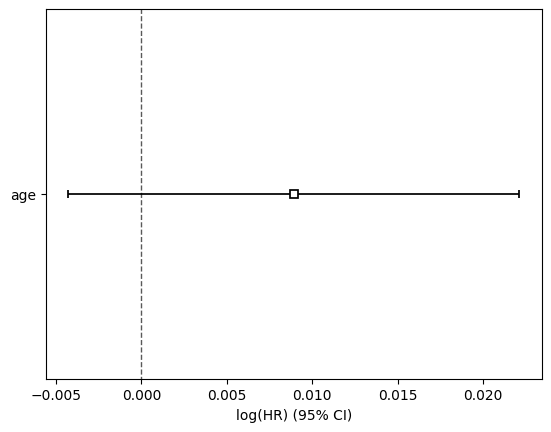

In [24]:
# Use just 'Age Date Dx Liver Cancer' for refit
age_col = 'Age Date Dx Liver Cancer'
X_age = X_nonzero_filtered[[age_col]]

# Prepare data as required by lifelines
df_lf = pd.DataFrame({
    'age': X_age[age_col].values,
    'duration': y['duration'],
    'event': y['event'].astype(int)
})

cph = CoxPHFitter()
cph.fit(df_lf, duration_col='duration', event_col='event')
cph.print_summary()  # Shows HR, 95% CI, and p-value

# You can also plot:
cph.plot()


In [26]:
# Split age at median for visualization
median_age = X_age[age_col].median()
age_group = X_age[age_col] > median_age

# Plot KM curves
plt.figure(figsize=(7,5))
for group, label in zip([False, True], [f'≤ Median ({median_age:.1f})', f'> Median ({median_age:.1f})']):
    mask = (age_group == group)
    time, survival_prob = kaplan_meier_estimator(
        y[mask]['event'], y[mask]['duration']
    )
    plt.step(time, survival_prob, label=label)
plt.xlabel('Time to Recurrence or Last Follow-Up')
plt.ylabel('Recurrence-Free Survival')
plt.title('Kaplan-Meier by Age Group')
plt.legend()
plt.tight_layout()
plt.show()


NameError: name 'plt' is not defined

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from lifelines import CoxPHFitter, KaplanMeierFitter

# Prepare data for lifelines
df_lf = pd.DataFrame({
    'age': X_age[age_col].values,
    'duration': y['duration'],
    'event': y['event'].astype(int)
})

# Stratify by age (median split)
median_age = df_lf['age'].median()
df_lf['age_group'] = np.where(df_lf['age'] > median_age, f'> Median ({median_age:.1f})', f'≤ Median ({median_age:.1f})')

# Fit Cox model
cph = CoxPHFitter()
cph.fit(df_lf[['age', 'duration', 'event']], duration_col='duration', event_col='event')

# Fit KM curves
kmf = KaplanMeierFitter()

fig, axes = plt.subplots(1, 2, figsize=(10, 5), gridspec_kw={'width_ratios': [2, 1]}, dpi=150)

# --- Left: KM Curves ---
ax_km = axes[0]
colors = ['#386cb0', '#fdb462']  # blue and orange for colorblind friendliness

for i, (group, grp_df) in enumerate(df_lf.groupby('age_group')):
    kmf.fit(grp_df['duration'], grp_df['event'], label=group)
    kmf.plot(ax=ax_km, ci_show=True, color=colors[i], lw=2, marker='o', markersize=4)

ax_km.set_title('Recurrence-Free Survival by Age Group', fontsize=14, weight='bold')
ax_km.set_xlabel('Time to Recurrence or Last Follow-Up', fontsize=12)
ax_km.set_ylabel('Survival Probability', fontsize=12)
ax_km.legend(title="Age Group")
ax_km.grid(axis='y', linestyle=':', alpha=0.5)
ax_km.spines['top'].set_visible(False)
ax_km.spines['right'].set_visible(False)

# --- Right: Forest Plot ---
ax_forest = axes[1]

# After fitting model and printing columns:
print(cph.confidence_intervals_.columns)  # Debugging, see actual column names

hr = np.exp(cph.params_['age'])
ci_low = np.exp(cph.confidence_intervals_.iloc[0, 0])
ci_high = np.exp(cph.confidence_intervals_.iloc[0, 1])

# Now your plotting code follows as before


ax_forest.errorbar(hr, 0, xerr=[[hr - ci_low], [ci_high - hr]],
                   fmt='o', color='#386cb0', ecolor='#386cb0', capsize=5, lw=2, markersize=7)
ax_forest.axvline(1, color='grey', linestyle='--', lw=1)
ax_forest.set_yticks([0])
ax_forest.set_yticklabels(['Age (per year)'], fontsize=12)
ax_forest.set_xlabel('Hazard Ratio (95% CI)', fontsize=12)
ax_forest.set_xlim(left=0.7, right=max(ci_high * 1.1, 1.5))
ax_forest.set_title('Cox Regression\n(Hazard Ratio)', fontsize=14, weight='bold')
ax_forest.spines['top'].set_visible(False)
ax_forest.spines['right'].set_visible(False)
ax_forest.spines['left'].set_visible(False)
ax_forest.yaxis.set_ticks_position('none')

# Remove y grid, tidy layout
ax_forest.grid(False)
plt.tight_layout(pad=2)
fig.subplots_adjust(wspace=0.35)
plt.show()
figpath = "Secondary_Tumor_Recurrence.png"
plt.savefig(figpath, dpi=600, bbox_inches='tight')
plt.savefig("Secondary_Tumor_Recurrence.png", dpi=600, bbox_inches='tight')
!cp Secondary_Tumor_Recurrence.png "/content/drive/My Drive/Tommy Rads/"

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/Tommy Rads/Primary_Tumor_Recurrence.csv', index_col=False, encoding='latin1')

In [ ]:
numeric_cols = df.select_dtypes(include=np.number).columns

# Apply the mask to only the numeric columns
df[numeric_cols] = df[numeric_cols].mask(df[numeric_cols] < 0)

print(df)

In [ ]:
# Replace '-' with NaN
df.replace('-', np.nan, inplace=True)

# Helper function to flag unexpected values
def flag_unexpected(series, expected_type, allowed_values=None, pattern=None):
    flagged = []
    for idx, val in series.items():
        if pd.isna(val):
            continue
        if allowed_values is not None and val not in allowed_values:
            flagged.append((idx, val))
        elif expected_type == 'numeric':
            try:
                float(str(val).replace('A','')) # '12A' becomes '12'
            except:
                flagged.append((idx, val))
        elif expected_type == 'binary':
            if str(val) not in ['0', '1']:
                flagged.append((idx, val))
        elif pattern is not None:
            if not re.match(pattern, str(val)):
                flagged.append((idx, val))
    return flagged

# Cleaning report dictionary
cleaning_report = {}

# Sex: Recode to binary Sex: Male
df['Sex'] = df['Sex'].str.strip().str.upper().replace({'MALE': 'M', 'FEMALE': 'F'})
sex_binary = df['Sex'].map({'M': 1, 'F': 0})
df['Sex: Male'] = sex_binary
cleaning_report['Sex'] = flag_unexpected(df['Sex'], 'str', allowed_values=['M', 'F'])

# Race
allowed_races = ['White', 'Black', 'Asian', 'Other', 'Unknown']
df['Race'] = df['Race'].astype(str).str.strip().str.title()
cleaning_report['Race'] = flag_unexpected(df['Race'], 'str', allowed_values=allowed_races)

# Ethnicity
allowed_ethnicities = ['Hispanic', 'Nothispanic', 'Unknown']
df['Ethnicity'] = df['Ethnicity'].astype(str).str.strip().str.title()
cleaning_report['Ethnicity'] = flag_unexpected(df['Ethnicity'], 'str', allowed_values=allowed_ethnicities)

# Type of cancer
df['CAT type of cancer'] = df['CAT type of cancer'].astype(str).str.strip().str.lower()

# Age
df['Age Date Dx Liver Cancer'] = pd.to_numeric(df['Age Date Dx Liver Cancer'], errors='coerce')
cleaning_report['Age Date Dx Liver Cancer'] = flag_unexpected(df['Age Date Dx Liver Cancer'], 'numeric')

# CAT HCV
allowed_hcv = [0, 2]
df['CAT HCV (2-SVR, 1 for chronic/present, 3 HBV 4 HAV)'] = pd.to_numeric(
    df['CAT HCV (2-SVR, 1 for chronic/present, 3 HBV 4 HAV)'], errors='coerce'
)
cleaning_report['CAT HCV'] = flag_unexpected(
    df['CAT HCV (2-SVR, 1 for chronic/present, 3 HBV 4 HAV)'], 'numeric', allowed_values=allowed_hcv)

# Binary columns
binary_cols = ['EtOH', 'NASH', 'Ascites', 'Encephalopathy', 'First AFP Elevated',
               'Unilobar (0), Bilobar (1)', 'Bx during ablation (0-no, 1-yes, 2-NGS)']
for col in binary_cols:
    allowed = ['0', '1'] if 'Bx during ablation' not in col else ['0', '1', '2']
    df[col] = df[col].astype(str).str.strip()
    df[col].replace('', np.nan, inplace=True)
    cleaning_report[col] = flag_unexpected(df[col], 'binary', allowed_values=allowed)
    df[col] = pd.to_numeric(df[col], errors='coerce')

# Scalar numeric columns
scalar_cols = ['WBC', 'Hgb', 'Plt', 'Na', 'Cr', 'Albumin', 'Tbili', 'INR', 'AFP1',
               '#tumors to ablate', 'Longest Diameter Largest lesion (mm)',
               'Sum Longest Diameters', 'PS', 'Time to recur']
for col in scalar_cols:
    df[col] = pd.to_numeric(df[col], errors='coerce')
    cleaning_report[col] = flag_unexpected(df[col], 'numeric')

# Segment Largest Index Lesion (integer, sometimes with an 'A' suffix)
def clean_segment(x):
    if pd.isna(x):
        return np.nan
    if isinstance(x, str) and x.endswith('A'):
        x = x[:-1]
    try:
        return int(x)
    except:
        return np.nan
df['Segment Largest Index Lesion'] = df['Segment Largest Index Lesion'].apply(clean_segment)
cleaning_report['Segment Largest Index Lesion'] = flag_unexpected(df['Segment Largest Index Lesion'], 'numeric')

# Liver Treatment prior to initial ablation
treatment_map = {
    '1': 'TACE',
    '2': 'TARE',
    '3': 'EBRT',
    '4': 'Systemic Therapy',
    '5': 'Resection',
    '6': 'Combined/Other'
}
def treatment_flags(cell):
    flags = {name: 0 for name in treatment_map.values()}
    if pd.isna(cell):
        return pd.Series(flags)
    items = re.findall(r'\d', str(cell))
    for item in items:
        if item in treatment_map:
            flags[treatment_map[item]] = 1
    return pd.Series(flags)
treatments = df['CAT Liver Treatment prior to initial ablation (0-none, 1-TACE, 2-TARE, 3-EBRT, 4-Systemic Therapy, 5-resection, 6-bland embo/other)'].apply(treatment_flags)
df = pd.concat([df, treatments], axis=1)
df.drop(columns=['CAT Liver Treatment prior to initial ablation (0-none, 1-TACE, 2-TARE, 3-EBRT, 4-Systemic Therapy, 5-resection, 6-bland embo/other)'], inplace=True)

# Recur (dependent)
df['Recur (0-no, 1-yes)'] = pd.to_numeric(df['Recur (0-no, 1-yes)'], errors='coerce')
cleaning_report['Recur (0-no, 1-yes)'] = flag_unexpected(df['Recur (0-no, 1-yes)'], 'binary', allowed_values=['0', '1'])

# Gather cleaning report and summarize any flagged values
flagged_summary = {col: flagged for col, flagged in cleaning_report.items() if flagged}
flagged_summary  # Show all columns with flagged/unexpected values and what those are


In [ ]:
# First CEA Elevated: Recode to binary integers
df['First AFP Elevated'] = df['First AFP Elevated'].replace({'1.0': 1, '0.0': 0}).astype(float)
# (Leave np.nan for missing)

# Bx during ablation: Create one-hot columns for Yes (1) and NGS (2)
df['Bx during ablation: Yes'] = (df['Bx during ablation (0-no, 1-yes, 2-NGS)'] == 1).astype(int)
df['Bx during ablation: NGS'] = (df['Bx during ablation (0-no, 1-yes, 2-NGS)'] == 2).astype(int)

# Show the first 10 rows of the cleaned dataframe for relevant columns
df[['First CEA Elevated', 'Bx during ablation (0-no, 1-yes, 2-NGS)',
    'Bx during ablation: Yes', 'Bx during ablation: NGS']].head(10)